# Logistic Regression

Logistic regression estimates the probability of an event occurring, such as voted or didn't vote, based on a given dataset of independent variables.

In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

from jax import grad
import jax.numpy as jnp

import polars as pl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

FS = (15, 10)  # figure size
RS = 42  # random seed

In [2]:
dataset_train = [
('send us your password', 'spam'),
('review our website', 'spam'),
('send your password', 'spam'),
('send us your account', 'spam'),
('Your activity report', 'ham'),
('benefits physical activity', 'ham'),
('the importance vows', 'ham'),
]

dataset_test = [
    ('renew your password', 'spam'),
    ('renew your vows', 'spam'),
    ('benefits of our account', 'ham'),
    ('the importance of physical activity', 'ham')
]

print(f'{dataset_train}')
print(f'{dataset_test}')

[('send us your password', 'spam'), ('review our website', 'spam'), ('send your password', 'spam'), ('send us your account', 'spam'), ('Your activity report', 'ham'), ('benefits physical activity', 'ham'), ('the importance vows', 'ham')]
[('renew your password', 'spam'), ('renew your vows', 'spam'), ('benefits of our account', 'ham'), ('the importance of physical activity', 'ham')]


In [3]:
corpus_train = [text for text,_ in dataset_train]
corpus_test =  [text for text,_ in dataset_test]

y_train = jnp.array([0 if label =='ham' else 1 for _, label in dataset_train])
y_test = jnp.array([0 if label =='ham' else 1 for _, label in dataset_test])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(corpus_train)
X_test_counts = count_vect.transform(corpus_test)
print(X_train_counts.shape)
print(count_vect.vocabulary_.get(u'password'))

(7, 15)
5


In [5]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts).toarray()
X_test_tfidf = tfidf_transformer.transform(X_test_counts).toarray()
print(f'{X_train_tfidf.shape}, {X_test_tfidf.shape}')

(7, 15), (4, 15)


## Inner Workings

Here we are going to look at the binary classification case, but it is straightforward to generalize the algorithm to multiclass classification.

Assume that we have $k$ predictor: ${X}^k_{i=1} \in \mathbb{R}$

and a binary response variable: $Y \in {0,1}$

In the logistic regression algorithm, the relationship between the predictors and the *logit* of the probability of a positive outcome $Y=1$ is assumed to be linear:

$$logit(P(Y=1|w))=c+\sum_{i=1}^kw_iX_i$$

where

$$\{w_i\}^k_{i=1} \in \mathbb{R}^k$$

are the linear weights and $c \in \mathbb{R}$ the intercept. Now what is the *logit* function? It is the log of odds:

$$logit(p)=\ln\left(\frac{p}{1−p}\right)$$

We see that the *logit* function is a way to map a probability value from $[0,1]$ to $\mathbb{R}$

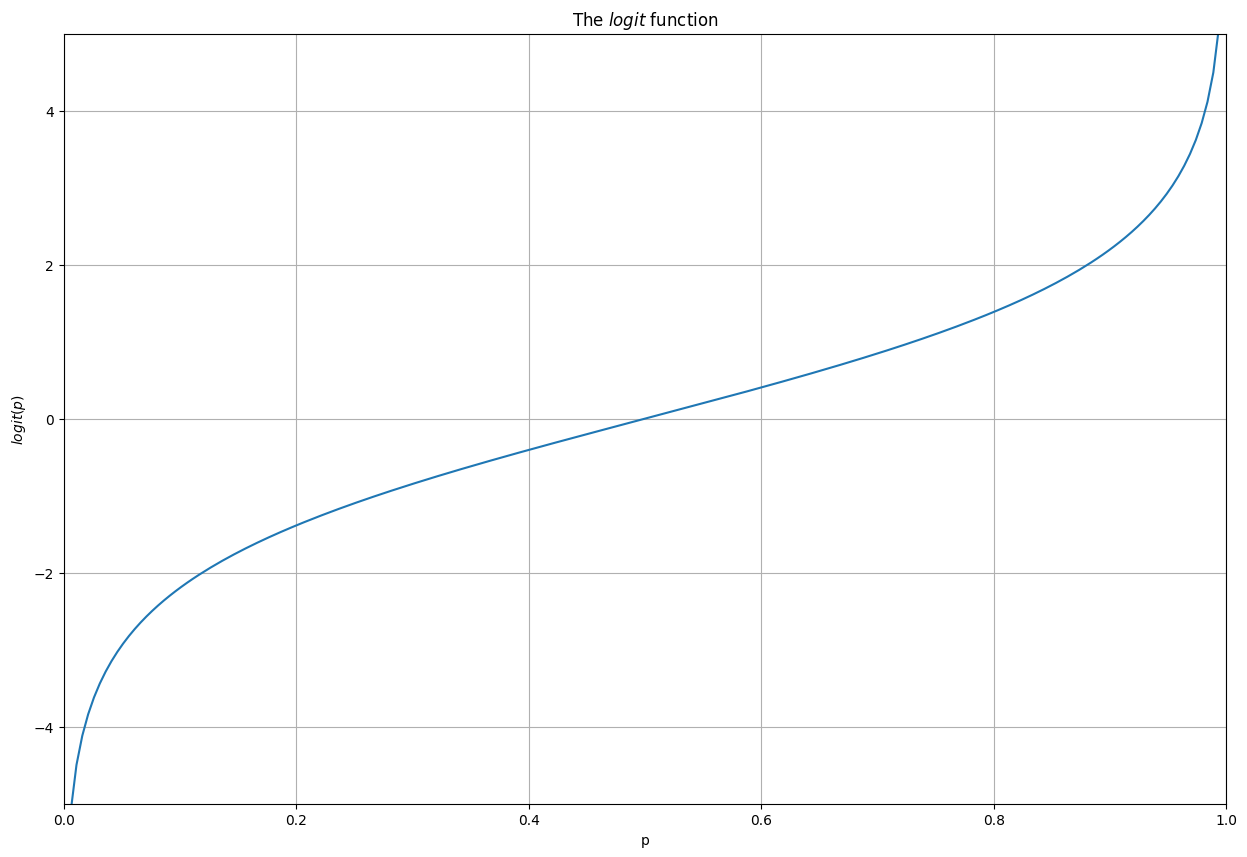

In [6]:
eps = 1e-3
p = jnp.linspace(eps, 1 - eps, 200)
_, ax = plt.subplots(figsize=FS)
plt.plot(p, jnp.log(p / (1 - p)))
ax.grid()
_ = ax.set(xlabel="p", ylabel="$logit(p)$", title="The $logit$ function")
_ = ax.set_xlim(0, 1)
_ = ax.set_ylim(-5, 5)

The inverse of the *logit* is the *logistic* curve [also called sigmoid function], which we are going to note $\sigma$:

$$\sigma(r)=\frac{1}{1+e^{−r}}$$

Here is the implementation of the *logistic* curve:

In [7]:
def logistic(r):
    return 1 / (1 + jnp.exp(-r))

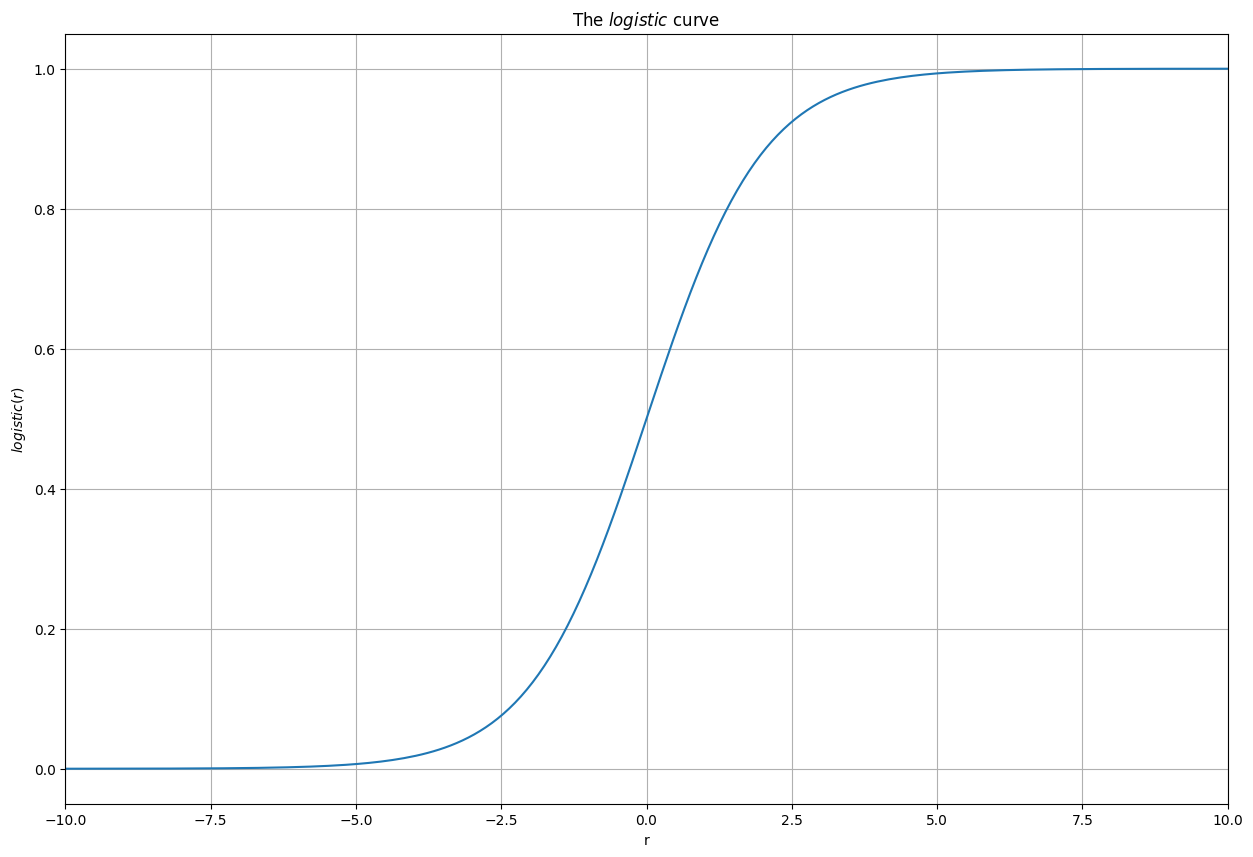

In [8]:
b = 10
r = jnp.linspace(-b, b, 200)
_, ax = plt.subplots(figsize=FS)
plt.plot(r, logistic(r))
ax.grid()
_ = ax.set(xlabel="r", ylabel="$logistic(r)$", title="The $logistic$ curve")
_ = ax.set_xlim(-b, b)

If we denote by $w=[c;w_1;...;w_k]^T$ the weight vector, $x=[1;x_1;...;x_k]^T$ the observed values of the predictors, and $y$ the associated class value, we have:

$$logit(P(y=1|w))=w^Tx$$

And thus:

$$P(y=1|w)=\sigma(w^Tx)≡\sigma_w(x)$$

For a given set of weights $w$, the probability of a positive outcome is $\sigma_w(x)$ that we implement in the following predict function:

In [9]:
def predict(c, w, X):
    return logistic(jnp.dot(X, w) + c)

This probability can be turned into a predicted class label \hat{y} using a threshold value:

$$\hat{y} = 1 ;  \text{if} ; \sigma_{\textbf{w}} (\textbf{x}) \geq 0.5, ; 0 ; \text{otherwise}$$

### Cost function

Now we assume that we have $n$ observations and that they are independently Bernoulli distributed:
$$\{ \left( \textbf{x}^{(1)}, y^{(1)} \right), \left( \textbf{x}^{(2)}, y^{(2)} \right), ...,  \left( \textbf{x}^{(n)}, y^{(n)} \right) \}$$

The likelihood that we would like to maximize given the samples is the following one:

$$
L(\textbf{w}) = \prod_{i=1}^n P( y^{(i)} | \textbf{x}^{(i)}; \textbf{w}) = \prod_{i=1}^n \sigma_{\textbf{w}} \left(\textbf{x}^{(i)} \right)^{y^{(i)}}  \left( 1- \sigma_{\textbf{w}} \left(\textbf{x}^{(i)} \right)\right)^{1-y^{(i)}}
$$

For some reasons related to numerical stability, we prefer to deal with a scaled log-likelihood. Also, we take the negative, in order to get a minimization problem:

$$
J(\textbf{w}) = - \frac{1}{n} \sum_{i=1}^n \left[  y^{(i)} \log \left(  \sigma_{\textbf{w}} \left(\textbf{x}^{(i)} \right) \right) +  \left( 1-y^{(i)} \right) \log \left( 1- \sigma_{\textbf{w}} \left(\textbf{x}^{(i)} \right)\right) \right] \tag{8}
$$

A great feature of this cost function is that it is differentiable and convex. A gradient-based algorithm should find the global minimum. Now let's also introduce some $l2$-regularization in order to improve the model:

$$J_r(\textbf{w}) = J(\textbf{w})  + \frac{\lambda}{2} \textbf{w}^T \textbf{w}$$

with $\lambda \geq 0$. Regularization is a very useful method to handle collinearity [high correlation among features], filter out noise from data, and eventually prevent overfitting.

Here is the cost function $J_r(\textbf{w})$:

In [10]:
def cost(c, w, X, y, eps=1e-14, lmbd=0.1):
    n = y.size
    p = predict(c, w, X)
    p = jnp.clip(p, eps, 1 - eps)  # bound the probabilities within (0,1) to avoid ln(0)
    return -jnp.sum(y * jnp.log(p) + (1 - y) * jnp.log(1 - p)) / n + 0.5 * lmbd * (jnp.dot(w, w) + c * c)

## Learning the weights

So we need to minimize $J_r(\textbf{w})$. For that we are going to apply Gradient descent.
This method requires the gradient of the cost function: $\nabla_{\textbf{w}} J_r(\textbf{w})$

### Compute the gradient

We could definitely compute the gradient of this Logistic regression cost function analytically. 
However we won't, because we are are lazy and want JAX to do it for us! However, we can say that JAX would be more relevant if applied to a very complex function for which an analytical derivative is very hard or impossible to compute, such as the cost function of a deep neural network for example.

So let's differentiate this cost function with respect to the first and second positional arguments using JAX' grad function.

In [11]:
class LR:
    def fit(self, X, y, n_iter = 1000, eta = 5e-2, tol = 1e-6):
        w = 1.0e-5 * jnp.ones(X.shape[1])
        c = 1.0
        new_cost = float(cost(c, w, X, y))
        cost_hist = [new_cost]
        for i in range(n_iter):
            c_current = c
            c -= eta * grad(cost, argnums=0)(c_current, w, X, y)
            w -= eta * grad(cost, argnums=1)(c_current, w, X, y)
            new_cost = float(cost(c, w, X, y))
            cost_hist.append(new_cost)
            if (i > 20) and (i % 10 == 0):
                if jnp.abs(cost_hist[-1] - cost_hist[-20]) < tol:
                    #print(f"Exited loop at iteration {i}")
                    break
        self.c = c
        self.w = w
        self.cost_hist = cost_hist
    
    def get_cost_hist(self):
        return self.cost_hist

    def predict(self, X):
        y_pred_proba = predict(self.c, self.w, X)
        y_pred = jnp.array(y_pred_proba)
        y_pred = jnp.where(y_pred < 0.5, y_pred, 1.0)
        y_pred = jnp.where(y_pred >= 0.5, y_pred, 0.0)
        return y_pred

In [12]:
clf = LR()
clf.fit(X_train_tfidf, y_train)

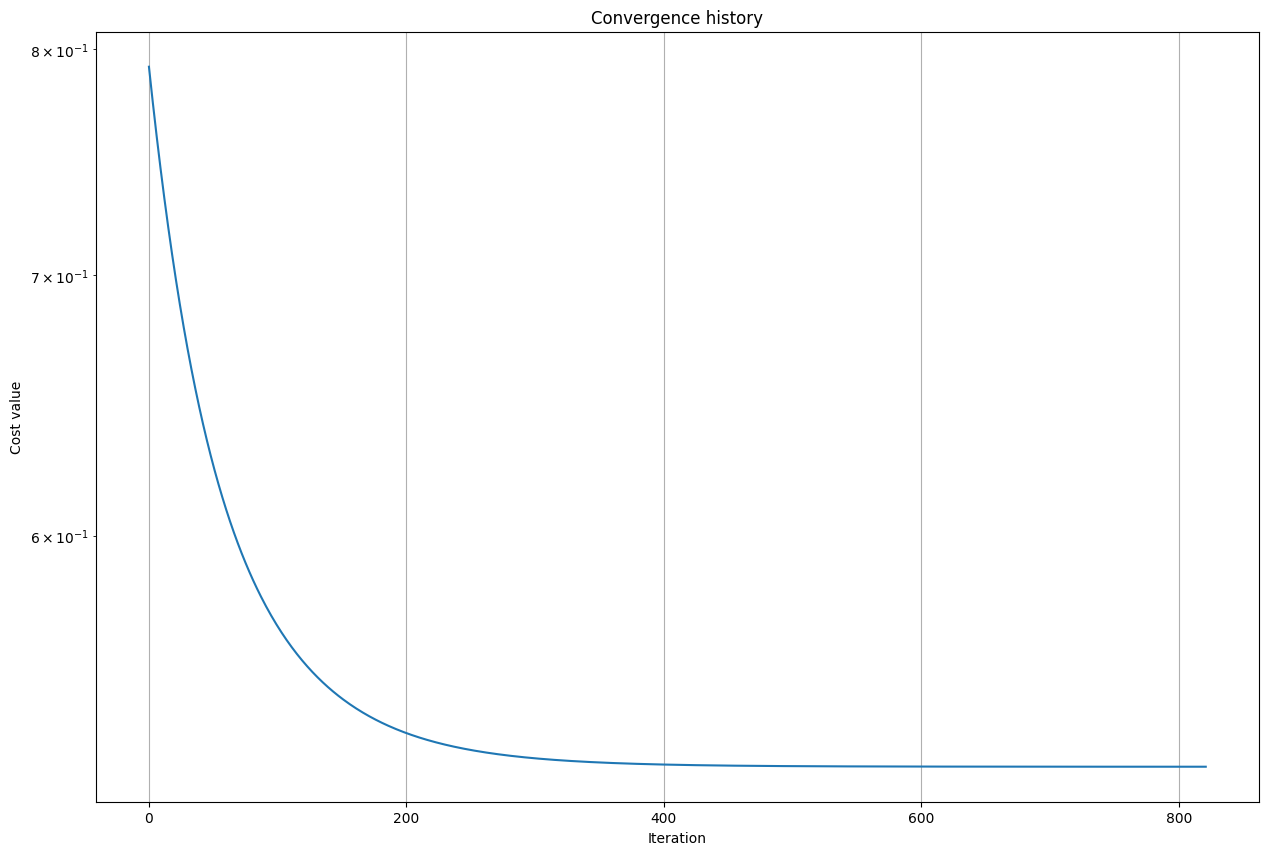

In [13]:
_, ax = plt.subplots(figsize=FS)
plt.semilogy(clf.get_cost_hist())
ax.grid()
_ = ax.set(xlabel="Iteration", ylabel="Cost value", title="Convergence history")

In [14]:
y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.50      0.50      0.50         2

    accuracy                           0.50         4
   macro avg       0.50      0.50      0.50         4
weighted avg       0.50      0.50      0.50         4



## Real Dataset

In [16]:
df = pl.read_csv('../../datasets/spam.csv')
df

Target,SMS
str,str
"""ham""","""Go until juron…"
"""ham""","""Ok lar... Joki…"
"""spam""","""Free entry in …"
"""ham""","""U dun say so e…"
"""ham""","""Nah I don't th…"
"""spam""","""FreeMsg Hey th…"
"""ham""","""Even my brothe…"
"""ham""","""As per your re…"
"""spam""","""WINNER!! As a …"


In [17]:
dataset = df.rows()
X = [text for _, text in dataset]
y = jnp.array([0 if label == 'ham' else 1 for label, _ in dataset])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [18]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts).toarray()
X_test_tfidf = tfidf_transformer.transform(X_test_counts).toarray()

In [19]:
clf = LR()
clf.fit(X_train_tfidf, y_train)

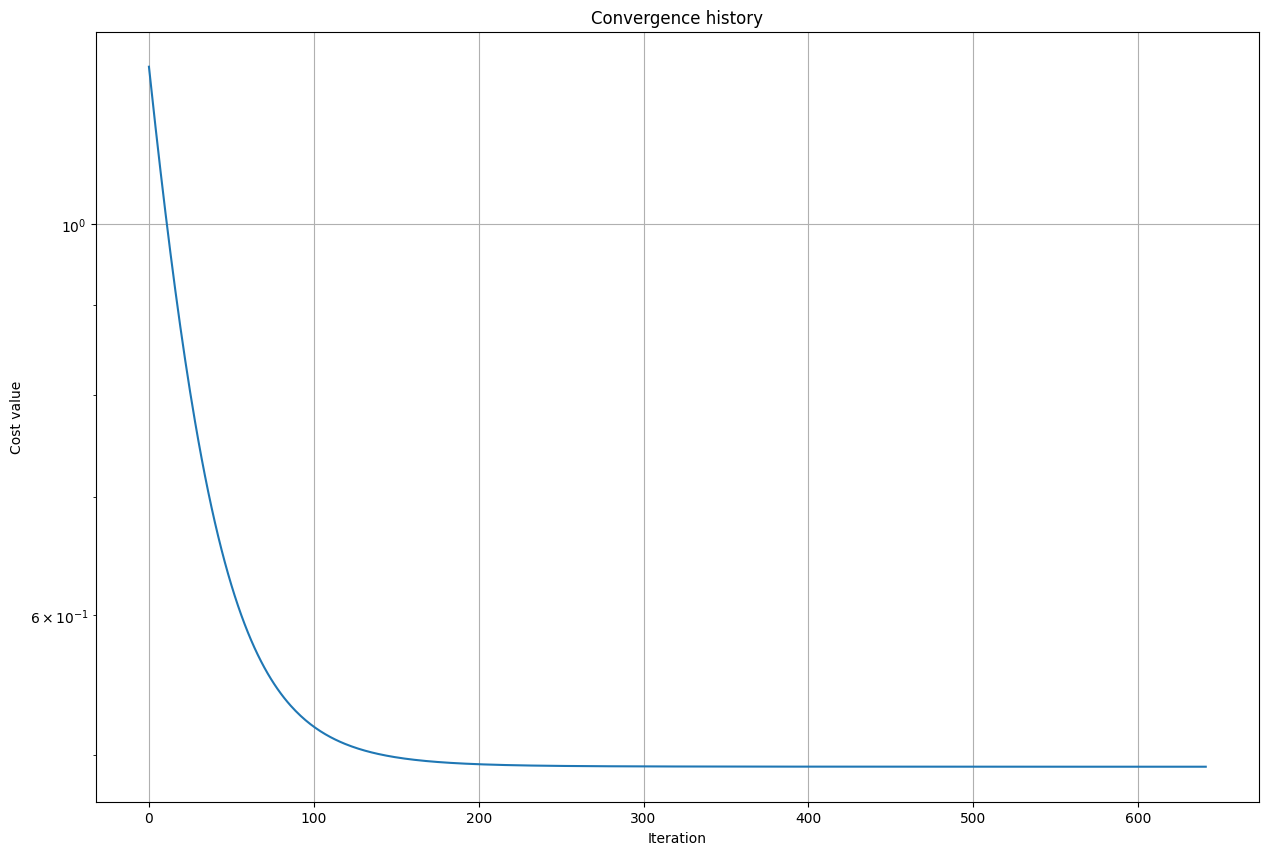

In [20]:
_, ax = plt.subplots(figsize=FS)
plt.semilogy(clf.get_cost_hist())
ax.grid()
_ = ax.set(xlabel="Iteration", ylabel="Cost value", title="Convergence history")

In [21]:
y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       956
           1       0.00      0.00      0.00       149

    accuracy                           0.87      1105
   macro avg       0.43      0.50      0.46      1105
weighted avg       0.75      0.87      0.80      1105



## Debug

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       101
           1       0.92      0.87      0.90        99

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



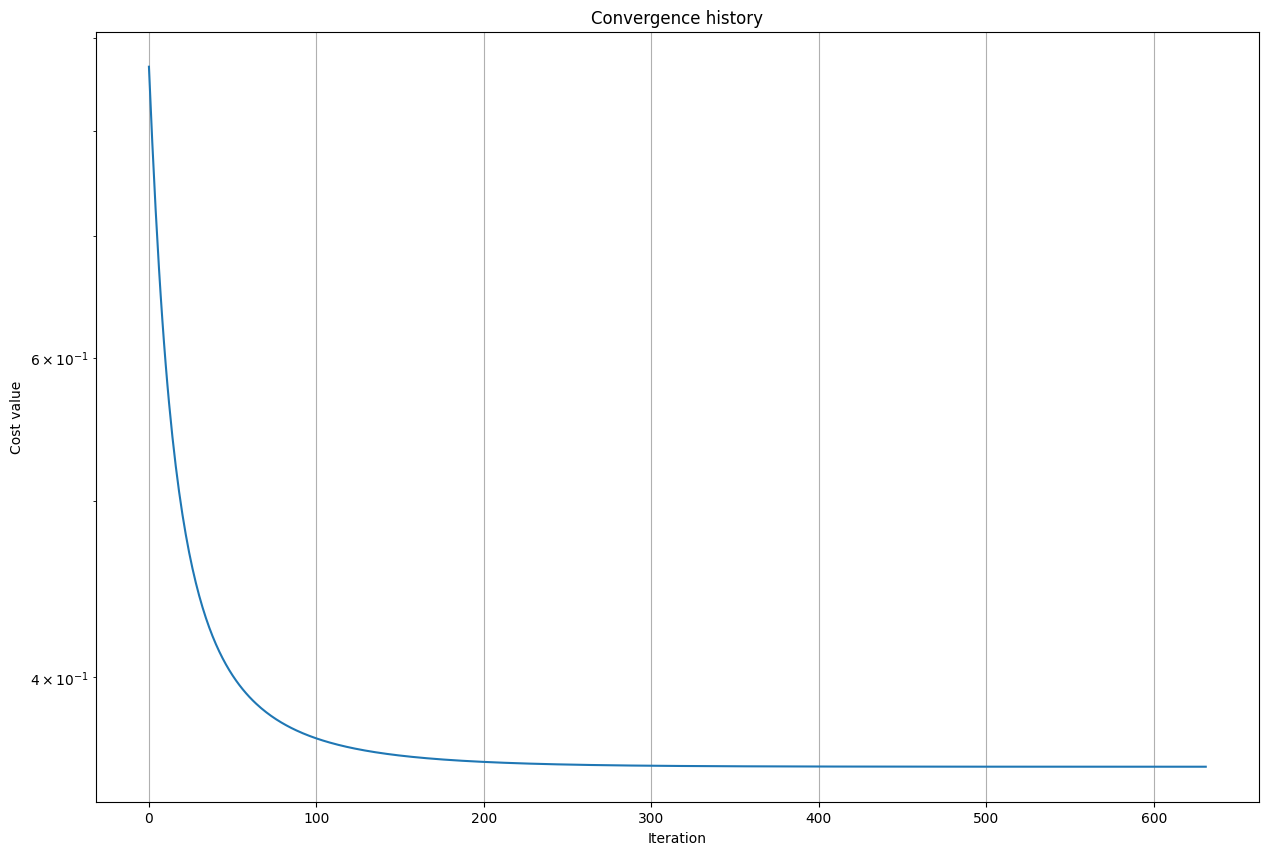

In [22]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=1000, # 1000 observations 
    n_features=5, # 5 total features
    n_informative=3, # 3 'useful' features
    n_classes=2, # binary target/label 
    random_state=42 # if you want the same results as mine
)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

clf = LR()
clf.fit(X_train, y_train)

_, ax = plt.subplots(figsize=FS)
plt.semilogy(clf.get_cost_hist())
ax.grid()
_ = ax.set(xlabel="Iteration", ylabel="Cost value", title="Convergence history")

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
